<a href="https://colab.research.google.com/github/MJ-best/-DACON-AI-/blob/main/%5BDACON%5DGenome_Info_clf_AI_20220116.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [DACON] 유전체 정보 품종 분류 AI 경진대회
- https://dacon.io/competitions/official/236035/overview/description
- 개체와 SNP 정보를 이용하여 품종 분류 AI 모델 개발
- 유전체 염기서열에서 획득한 유전체 변이 정보인 Single Nucleotide Polymorphism 정보는 특정 개체 및 특정 품종에 따라 다른 변이 양상을 나타낼 수 있기 때문에 동일개체를 확인하거나, 동일 품종을 구분하는데 활용이 가능합니다. 따라서 이번 경진대회에서는 개체 정보와 SNP 정보를 이용하여 A, B, C 품종을 분류하는 최고의 품종구분 정확도를 획득하는 것이 목표입니다.

- 농축수산 현장에서는 유전체 변이정보를 이용해서 품종을 구분하는 연구를 통해 품종의 다양성 혹은 품종 부정유통을 방지하기 위해 많이 활용하게 됩니다.

- SNP란 DNA 내 A, T, G, C와 같은 염기서열의 차이로서 개체 간 염기서열의 차이 정도를 파악하여 분자적인 수준에서의 명확한 품종 조성 확인을 가능케 한다

- 많은 SNP 정보를 통해 분류하는 것보다, 보다 **더 적은 SNP 정보로 높은 분류 성능**을 내는 것이 중요합니다.

- 따라서 이번 경진대회에서는 개체 정보와 사전에 구성된 **15개의 SNP 정보를 바탕으로 품종 분류 모델을 개발**해야 합니다.



In [2]:
import datetime
from pytz import timezone

print("last update : ",datetime.datetime.now(timezone('Asia/Seoul')))

last update :  2023-01-16 18:32:34.020778+09:00


In [3]:
import io
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

import tensorflow as tf

## 데이터준비

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/[DACON]유전체정보_품좀_분류_AI_경진대회/data'
os.chdir(path)
df = pd.read_csv("train.csv", encoding='utf-8-sig', error_bad_lines=False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,...,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,0,0,0,2,G G,A G,A A,G A,C A,...,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,0,0,0,2,A G,A G,C A,A A,A A,...,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,0,0,0,2,G G,G G,A A,G A,C C,...,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,0,0,0,2,G G,G G,C C,A A,C C,...,A A,A A,A A,G G,A A,A A,A G,A A,G A,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,TRAIN_257,0,0,0,2,A G,A G,A A,G A,C C,...,A A,G A,A A,G G,A G,G A,A A,A A,A A,B
258,TRAIN_258,0,0,0,2,G G,A A,C A,A A,A A,...,G A,G A,A A,A G,A G,A A,A G,A A,G A,C
259,TRAIN_259,0,0,0,1,A G,G G,A A,G A,A A,...,G G,G A,G A,A A,G G,G G,G G,C A,G G,A
260,TRAIN_260,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G A,A G,A G,G A,G G,C A,G G,A


In [7]:
data = df.drop(['id', 'father', 'mother', 'gender', 'trait','class'], axis = 1)

In [8]:
target = df['class']

In [9]:
info = pd.read_csv("snp_info.csv", encoding='utf-8-sig', error_bad_lines=False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
info

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


- name : SNP 명
- chrom : 염색체 정보
- cm : Genetic distance
- pos : 각 마커의 유전체상 위치 정보

- 내가 알기로 Genetic distance가 가까울 수록 비슷한 종이고 멀수록 서로 많이 다른 종자가 된다. (computing genetic distance, we can estimate how long ago the two populations were separated)

- SNP는 DNA의 어느 한 부분을 뜻하는 말이고, 여기에 올 수 있는 DNA code가 일반적으로 2종류여서 예를 들어 SNP-1은 A, G가 올수 있기 때문에 SNP-1자리에 올 수 있는 유전자형은 AA, AG, GG 세가지가 된다.

-http://www.incodom.kr/SNP#h_2c088d3d06d5a44395884bd694e4f8ac

## 데이터 전처리
- class(y_train, y_test)는 다중분류므로 라벨 인코딩과 원핫 인코딩을 적용해준다
- SNP는 만들어지는 경우의 수가 3가지 뿐이므로 각 열을 따로 인코딩 해준다
- 0,1,2로 나눠지는 데이터를 MinMax로 0~1 사이로 만들어준다

In [11]:
class CFG:
    SEED = 42

In [12]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=CFG.SEED, stratify=target)

- y데이터(라벨링)에는 원핫 인코딩을 적용해준다

In [14]:
#먼저 라벨 인코더
target_label = preprocessing.LabelEncoder()
y_train_scaled_ = target_label.fit_transform(y_train)

In [15]:
#원핫인코더
from keras.utils import np_utils
y_train_scaled = np_utils.to_categorical(y_train_scaled_)

- 각 SNP별로 따로따로 인코딩

In [16]:
snp_1 =  preprocessing.LabelEncoder()
snp_2 =  preprocessing.LabelEncoder()
snp_3 =  preprocessing.LabelEncoder()
snp_4 =  preprocessing.LabelEncoder()
snp_5 =  preprocessing.LabelEncoder()
snp_6 =  preprocessing.LabelEncoder()
snp_7 =  preprocessing.LabelEncoder()
snp_8 =  preprocessing.LabelEncoder()
snp_9 =  preprocessing.LabelEncoder()
snp_10 =  preprocessing.LabelEncoder()
snp_11 =  preprocessing.LabelEncoder()
snp_12 =  preprocessing.LabelEncoder()
snp_13 =  preprocessing.LabelEncoder()
snp_14 =  preprocessing.LabelEncoder()
snp_15 =  preprocessing.LabelEncoder()

In [17]:
snp_1.fit(data['SNP_01'])
snp_2.fit(data['SNP_02'])
snp_3.fit(data['SNP_03'])
snp_4.fit(data['SNP_04'])
snp_5.fit(data['SNP_05'])
snp_6.fit(data['SNP_06'])
snp_7.fit(data['SNP_07'])
snp_8.fit(data['SNP_08'])
snp_9.fit(data['SNP_09'])
snp_10.fit(data['SNP_10'])
snp_11.fit(data['SNP_11'])
snp_12.fit(data['SNP_12'])
snp_13.fit(data['SNP_13'])
snp_14.fit(data['SNP_14'])
snp_15.fit(data['SNP_15'])

LabelEncoder()

In [18]:
X_train['SNP_01'] = snp_1.transform(X_train['SNP_01'])
X_train['SNP_02'] = snp_2.transform(X_train['SNP_02'])
X_train['SNP_03'] = snp_3.transform(X_train['SNP_03'])
X_train['SNP_04'] = snp_4.transform(X_train['SNP_04'])
X_train['SNP_05'] = snp_5.transform(X_train['SNP_05'])
X_train['SNP_06'] = snp_6.transform(X_train['SNP_06'])
X_train['SNP_07'] = snp_7.transform(X_train['SNP_07'])
X_train['SNP_08'] = snp_8.transform(X_train['SNP_08'])
X_train['SNP_09'] = snp_9.transform(X_train['SNP_09'])
X_train['SNP_10'] = snp_10.transform(X_train['SNP_10'])
X_train['SNP_11'] = snp_11.transform(X_train['SNP_11'])
X_train['SNP_12'] = snp_12.transform(X_train['SNP_12'])
X_train['SNP_13'] = snp_13.transform(X_train['SNP_13'])
X_train['SNP_14'] = snp_14.transform(X_train['SNP_14'])
X_train['SNP_15'] = snp_15.transform(X_train['SNP_15'])

In [19]:
X_train.head()

,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
123,1,1,0,2,0,2,2,0,2,0,2,1,2,1,1
189,2,0,1,0,0,1,0,1,0,1,0,0,1,0,0
49,0,2,0,1,0,2,2,0,1,0,2,1,2,1,2
198,2,1,1,0,2,0,0,2,1,2,2,0,1,0,1
29,1,2,0,1,0,2,2,0,1,0,2,2,2,0,2


In [20]:
X_test['SNP_01'] = snp_1.transform(X_test['SNP_01'])
X_test['SNP_02'] = snp_2.transform(X_test['SNP_02'])
X_test['SNP_03'] = snp_3.transform(X_test['SNP_03'])
X_test['SNP_04'] = snp_4.transform(X_test['SNP_04'])
X_test['SNP_05'] = snp_5.transform(X_test['SNP_05'])
X_test['SNP_06'] = snp_6.transform(X_test['SNP_06'])
X_test['SNP_07'] = snp_7.transform(X_test['SNP_07'])
X_test['SNP_08'] = snp_8.transform(X_test['SNP_08'])
X_test['SNP_09'] = snp_9.transform(X_test['SNP_09'])
X_test['SNP_10'] = snp_10.transform(X_test['SNP_10'])
X_test['SNP_11'] = snp_11.transform(X_test['SNP_11'])
X_test['SNP_12'] = snp_12.transform(X_test['SNP_12'])
X_test['SNP_13'] = snp_13.transform(X_test['SNP_13'])
X_test['SNP_14'] = snp_14.transform(X_test['SNP_14'])
X_test['SNP_15'] = snp_15.transform(X_test['SNP_15'])

In [21]:
X_test.head(5)

,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
15,0,2,0,2,0,2,2,0,2,1,1,1,2,2,2
139,2,2,1,1,2,0,0,2,0,2,0,0,0,0,1
204,0,2,0,1,0,2,2,0,1,1,2,2,2,0,2
114,2,2,1,0,1,1,0,2,0,2,1,0,1,0,0
16,0,2,0,2,0,2,2,0,1,2,1,2,2,1,2


In [22]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_ = scaler.transform(X_train)
X_test_scaled_ = scaler.transform(X_test)

In [23]:
X_train_scaled = pd.DataFrame(X_train_scaled_, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_, columns=X_test.columns, index=X_test.index)

In [24]:
X_train_scaled.head(5)

,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
123,0.5,0.5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.5,1.0,0.5,0.5
189,1.0,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0
49,0.0,1.0,0.0,0.5,0.0,1.0,1.0,0.0,0.5,0.0,1.0,0.5,1.0,0.5,1.0
198,1.0,0.5,0.5,0.0,1.0,0.0,0.0,1.0,0.5,1.0,1.0,0.0,0.5,0.0,0.5
29,0.5,1.0,0.0,0.5,0.0,1.0,1.0,0.0,0.5,0.0,1.0,1.0,1.0,0.0,1.0


### n차원의 PCA를 실행함으로서 분산데이터의 유실을 거의 줄이면서 분류를 위한 특성변환을 한다


In [60]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## 평가지표
- F1 macro를 사용해 평가한다

In [25]:
#머신러닝 평가지표
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)*100
    precision = precision_score(y_test, pred, average='macro')*100
    recall = recall_score(y_test, pred, average='macro')*100
    f1_macro = f1_score(y_test, pred,  average='macro')
    
    print('오차행렬')
    print(confusion)
    print('정확도 :',"%.1f"%accuracy+'%')
    print('정밀도 :',"%.1f"%precision+'%')
    print('재현율 :', "%.1f"%recall+'%')
    print('Macro F1 score :', f1_macro)

In [26]:
#딥러닝 평가지표(케라스)
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

## 머신러닝 알고리즘

In [27]:
#Scikit-Optimize를 이용해 파라미터 자동 튜닝
!pip install -q scikit-optimize 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 8.0 MB/s eta 0:00:00


### 랜덤포레스트 모델을 사용해서 학습
- 분류기 : ran_clf
- F1 score : 0.916

In [28]:
ran_clf = RandomForestClassifier(random_state=CFG.SEED)
ran_clf.fit(X_train_scaled, y_train_scaled)
ran_pred_scaled = ran_clf.predict(X_test_scaled)

In [29]:
#원 핫 인코딩 -> 라벨 -> 
index = np.argmax(ran_pred_scaled, axis=1)
ran_pred = pd.DataFrame()
ran_pred = target_label.inverse_transform(index)

In [30]:
get_clf_eval(y_test, ran_pred)

오차행렬
[[14  0  0]
 [ 0 23  0]
 [ 2  2 12]]
정확도 : 92.5%
정밀도 : 93.2%
재현율 : 91.7%
Macro F1 score : 0.9162698412698412


### PCA를 통해 변환한 데이터셋이 좀더 정확도가 상승했다

In [61]:
ran_clf_1 = RandomForestClassifier(random_state=CFG.SEED)
ran_clf_1.fit(X_train_pca, y_train_scaled_)
ran_pred_scaled_1 = ran_clf_1.predict(X_test_pca)

In [63]:
ran_pred_1 = target_label.inverse_transform(ran_pred_scaled_1)

In [64]:
get_clf_eval(y_test, ran_pred_1)

오차행렬
[[14  0  0]
 [ 0 22  1]
 [ 0  3 13]]
정확도 : 92.5%
정밀도 : 93.6%
재현율 : 92.3%
Macro F1 score : 0.9277777777777777


### GBM 모델을 사용해서 학습
- 분류기 : gb_clf
- F1 score : 0.9638
- 파라미터 튜닝후 F1 score : 0.9638

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=CFG.SEED)
gb_clf.fit(X_train_scaled, y_train_scaled_)
gb_pred_scaled_ = gb_clf.predict(X_test_scaled)

In [32]:
# 라벨인코더 -> 타겟
gb_pred = target_label.inverse_transform(gb_pred_scaled_)

In [33]:
get_clf_eval(y_test, gb_pred)

오차행렬
[[14  0  0]
 [ 0 23  0]
 [ 0  2 14]]
정확도 : 96.2%
정밀도 : 97.3%
재현율 : 95.8%
Macro F1 score : 0.9638888888888889


In [34]:
gb_clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [35]:
from skopt import BayesSearchCV

gb_clf = GradientBoostingClassifier(random_state=CFG.SEED)

gb_opt = BayesSearchCV(
    gb_clf,
    {
    'n_estimators' : (100, 1000),
    'min_samples_split': (2,4),
    'learning_rate': (0.01, 0.1)
    },
    n_iter = 10,
    cv = 5
)

gb_opt.fit(X_train_scaled, y_train_scaled_)

gb_opt_pred_scaled_ = gb_opt.predict(X_test_scaled)

In [36]:
gb_opt_pred = target_label.inverse_transform(gb_opt_pred_scaled_)

In [37]:
get_clf_eval(y_test, gb_opt_pred)

오차행렬
[[14  0  0]
 [ 0 23  0]
 [ 0  2 14]]
정확도 : 96.2%
정밀도 : 97.3%
재현율 : 95.8%
Macro F1 score : 0.9638888888888889


In [38]:
gb_opt.best_params_

OrderedDict([('learning_rate', 0.050034926107103674),
             ('min_samples_split', 4),
             ('n_estimators', 194)])

### Linear SVC 모델을 이용해 학습
- 분류기 : svm
- F1 score : 0.927
- 파라미터 튜닝후 : 0.982

In [39]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state=CFG.SEED)
svm.fit(X_train_scaled, y_train_scaled_)
svm_pred_scaled_ = svm.predict(X_test_scaled)

In [40]:
# 라벨인코더 -> 타겟
svm_pred = target_label.inverse_transform(svm_pred_scaled_)

In [41]:
get_clf_eval(y_test, svm_pred)

오차행렬
[[14  0  0]
 [ 0 22  1]
 [ 0  3 13]]
정확도 : 92.5%
정밀도 : 93.6%
재현율 : 92.3%
Macro F1 score : 0.9277777777777777


In [42]:
#svm의 하이퍼파라미터를 조회해보자
svm.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [ ]:
from skopt import BayesSearchCV

svm = LinearSVC(random_state=CFG.SEED)

svm_opt = BayesSearchCV(
    svm,
    {'C' : (10.0, 100.0, 'log-uniform'),
     'max_iter': (1000, 10000),
    },
    n_iter = 10,
    cv = 5
)

svm_opt.fit(X_train_scaled, y_train_scaled_)

svm_opt_pred_scaled_ = svm_opt.predict(X_test_scaled)

In [44]:
svm_opt_pred = target_label.inverse_transform(svm_opt_pred_scaled_)

In [45]:
get_clf_eval(y_test, svm_opt_pred)

오차행렬
[[14  0  0]
 [ 0 23  0]
 [ 0  1 15]]
정확도 : 98.1%
정밀도 : 98.6%
재현율 : 97.9%
Macro F1 score : 0.9821551132463967


In [46]:
svm_opt.best_params_

OrderedDict([('C', 37.540218527310444), ('max_iter', 4432)])

### KNN을 이용한 분류기


In [47]:
from sklearn.neighbors import KNeighborsClassifier 
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

### 로지스틱 분류기


In [48]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()

### 스태킹모델을 이용해 성능을 끌어올려보자
- KNN : knn_clf
- Random Forest : ran_clf
- SVC : svm_opt
- GBM : gb_opt
- Logistic : logit



In [49]:
from sklearn.model_selection import KFold

# 메타 모델을 위한 학습 및 테스트 데이터 만들기
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=CFG.SEED)
    # 빈 배열 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('폴드 세트 : ', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index] 
        
        # 폴드 내 모델 학습
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) # y_train 예측, 폴드 끝나면 concat해야함
        test_pred[:, folder_counter] = model.predict(X_test_n) # y_test 예측, 폴드 끝나면 평균 낼거임
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean # 하나의 모델에 대한 학습데이터, 테스트 데이터 생성

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression # 메타 모델

# 객체 생성
#knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
#svm_opt
#gb_opt
logit = LogisticRegression()
lr_final = LogisticRegression()

# 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기
#knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train_scaled, y_train_scaled_, X_test_scaled, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train_scaled, y_train_scaled_, X_test_scaled, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train_scaled, y_train_scaled_, X_test_scaled, 7)
svm_train, svm_test = get_stacking_base_datasets(svm_opt, X_train_scaled, y_train_scaled_, X_test_scaled, 7)
gb_train, gb_test = get_stacking_base_datasets(gb_opt, X_train_scaled, y_train_scaled_, X_test_scaled, 7)
logit_train, logit_test = get_stacking_base_datasets(logit, X_train_scaled, y_train_scaled_, X_test_scaled, 7)

# 개별 모델로부터 나온 y_train 예측값들 옆으로 붙이기
Stack_final_X_train = np.concatenate((rf_train,ada_train,svm_train,gb_train,logit_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_final_X_test = np.concatenate((rf_train,ada_train,svm_train,gb_train,logit_train), axis=1)

lr_final.fit(Stack_final_X_train, y_train_scaled_)
stack_final = lr_final.predict(Stack_final_X_test) 

폴드 세트 :  0  시작


KeyError: ignored

### 분류에 도움이 되는 주요한 데이터에 관해서만 학습
- 2022년 12월 30일
- 시도해봤는데 머신러닝에서도 딥러닝에서도 좋은 성능을 얻지 못했다
- Xtra-tree : Macro F1 score 0.17316017316017315
- Deeplearning : Macro F1 score 0.07165532879818594

In [ ]:
#변수별 중요도를 이용해 특성행렬 선택후 학습
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(ran_clf, threshold = 'median')

In [ ]:
X_train_feature_important = selector.fit_transform(X_train_scaled, y_train)
X_test_feature_important = selector.fit_transform(X_test_scaled, y_test)

In [ ]:
# 엑스트라 트리로 주요변수에 대해서만 학습
from sklearn.ensemble import ExtraTreesClassifier
clf_important = ExtraTreesClassifier(n_estimators=100, random_state=CFG.SEED)
clf_important.fit(X_train_feature_important, y_train)

In [ ]:
pred1 = clf_important.predict(X_test_feature_important)

In [ ]:
get_clf_eval(y_test.values, preds1)

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=8, activation='relu', input_dim=X_train_feature_important.shape[1]),
                             tf.keras.layers.Dense(units=100, activation='relu'),
                             tf.keras.layers.Dense(units=100, activation='relu'),
                             tf.keras.layers.Dense(units=3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.07),
              loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])

model.summary()

In [ ]:
history = model.fit(X_train_feature_important, y_train, epochs=1000, batch_size=50, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

In [ ]:
y_hat = model.predict(X_test_feature_important)

In [ ]:
index = np.argmax(y_hat, axis=1)

In [ ]:
preds = pd.DataFrame()
preds = target_label.inverse_transform(index)

In [ ]:
get_clf_eval(y_test, preds)

## 딥러닝 다중분류모델을 이용해서 풀어보자

In [65]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam

### Dropout를 이용한 다중분류모델
- F1 score : 0.982


In [66]:
dna_model = Sequential()
dna_model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(192, activation='relu'))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(192, activation='relu'))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(192, activation='relu'))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(3, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
dna_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy',precision, recall, f1score])

dna_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1024      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 192)               12480     
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense_2 (Dense)             (None, 192)               37056     
                                                                 
 dropout_2 (Dropout)         (None, 192)               0         
                                                                 
 dense_3 (Dense)             (None, 192)               3

In [72]:
hist = dna_model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=100, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_f1score')])

Epoch 1/500
2/2 [==============================] - 1s 350ms/step - loss: 33.7741 - accuracy: 0.1859 - precision: 0.1882 - recall: 0.1882 - f1score: 0.1882 - val_loss: 5.7835 - val_accuracy: 0.3208 - val_precision: 0.3208 - val_recall: 0.3208 - val_f1score: 0.3208
Epoch 2/500
2/2 [==============================] - 0s 36ms/step - loss: 5.6733 - accuracy: 0.2756 - precision: 0.2872 - recall: 0.2757 - f1score: 0.2813 - val_loss: 1.1108 - val_accuracy: 0.3585 - val_precision: 0.3784 - val_recall: 0.2642 - val_f1score: 0.3111
Epoch 3/500
2/2 [==============================] - 0s 29ms/step - loss: 1.5662 - accuracy: 0.3590 - precision: 0.4307 - recall: 0.2661 - f1score: 0.3225 - val_loss: 1.0646 - val_accuracy: 0.3396 - val_precision: 0.4444 - val_recall: 0.1509 - val_f1score: 0.2254
Epoch 4/500
2/2 [==============================] - 0s 30ms/step - loss: 1.1669 - accuracy: 0.4038 - precision: 0.3939 - recall: 0.1786 - f1score: 0.2424 - val_loss: 1.1387 - val_accuracy: 0.2264 - val_precision: 

In [77]:
# pca로 변환한 열을 이용해 학습
hist = dna_model.fit(X_train_pca, y_train_scaled, epochs=500, batch_size=100, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_f1score')])

Epoch 1/500
2/2 [==============================] - 0s 86ms/step - loss: 2.7840 - accuracy: 0.2756 - precision: 0.2822 - recall: 0.2718 - f1score: 0.2769 - val_loss: 1.3987 - val_accuracy: 0.3585 - val_precision: 0.3654 - val_recall: 0.3585 - val_f1score: 0.3619
Epoch 2/500
2/2 [==============================] - 0s 30ms/step - loss: 1.6783 - accuracy: 0.3269 - precision: 0.3406 - recall: 0.3029 - f1score: 0.3205 - val_loss: 1.1476 - val_accuracy: 0.3774 - val_precision: 0.4634 - val_recall: 0.3585 - val_f1score: 0.4043
Epoch 3/500
2/2 [==============================] - 0s 32ms/step - loss: 1.1893 - accuracy: 0.3013 - precision: 0.3288 - recall: 0.2182 - f1score: 0.2615 - val_loss: 1.1292 - val_accuracy: 0.4340 - val_precision: 0.7333 - val_recall: 0.2075 - val_f1score: 0.3235
Epoch 4/500
2/2 [==============================] - 0s 33ms/step - loss: 0.9977 - accuracy: 0.4936 - precision: 0.6295 - recall: 0.2682 - f1score: 0.3733 - val_loss: 1.0732 - val_accuracy: 0.5283 - val_precision: 1.

In [73]:
y_hat = dna_model.predict(X_test_scaled)

2/2 [==============================] - 0s 6ms/step


In [78]:
#pca 변환된 행을 학습
y_hat = dna_model.predict(X_test_pca)

2/2 [==============================] - 0s 7ms/step


In [79]:
index = np.argmax(y_hat, axis=1)
dna_pred = pd.DataFrame()
dna_pred = target_label.inverse_transform(index)

In [80]:
get_clf_eval(y_test, dna_pred)

오차행렬
[[14  0  0]
 [ 0 23  0]
 [ 0  0 16]]
정확도 : 100.0%
정밀도 : 100.0%
재현율 : 100.0%
Macro F1 score : 1.0


- 시각화

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "x", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Adam을 이용한 다중분류모델
- F1 score : 0.94

In [ ]:
adam_model = Sequential()
adam_model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
adam_model.add(Dense(192, activation='relu'))
adam_model.add(Dense(192, activation='relu'))
adam_model.add(Dense(192, activation='relu'))
adam_model.add(Dense(units=3, activation='softmax'))

adam_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])

adam_model.summary()

In [ ]:
hist = adam_model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=100, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_f1score')])

In [ ]:
y_hat = adam_model.predict(X_test_scaled)

In [ ]:
index = np.argmax(y_hat, axis=1)

In [ ]:
preds = pd.DataFrame()
preds = target_label.inverse_transform(index)

In [ ]:
get_clf_eval(y_test, preds)

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "x", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## 드롭아웃을 적용시켜 아주 깊은 딥러닝 모델을 만들어보자
- 드롭아웃층을 적용했다
- 깊은 모델일 때 relu보다 좀더 미분값 소실이 적다는 swish함수를 사용했다

In [ ]:
model1 = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=1050, activation='swish', input_dim=X_train_scaled.shape[1]),
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dropout(0.2), 
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dropout(0.2), 
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dropout(0.2), 
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dropout(0.2), 
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dropout(0.2), 
                             tf.keras.layers.Dense(units=100, activation='swish'),
                             tf.keras.layers.Dense(units=3, activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.07),
              loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])

model1.summary()

In [ ]:
history = model1.fit(X_train_scaled, y_train, epochs=1000, batch_size=32, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])

In [ ]:
y_hat1 = model1.predict(X_test_scaled)

In [ ]:
index1 = np.argmax(y_hat1, axis=1)

In [ ]:
preds1 = pd.DataFrame()
preds1 = target_label.inverse_transform(index1)

In [ ]:
get_clf_eval(y_test, preds1)

- 어째 결과가 더 안좋게 나오네...


 # 제출용 데이터

### 데이터준비

In [85]:
path = '/content/drive/MyDrive/Colab Notebooks/[DACON]유전체정보_품좀_분류_AI_경진대회/data'
os.chdir(path)
train = pd.read_csv("train.csv", encoding='utf-8-sig', error_bad_lines=False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [86]:
path = '/content/drive/MyDrive/Colab Notebooks/[DACON]유전체정보_품좀_분류_AI_경진대회/data'
os.chdir(path)
test = pd.read_csv("test.csv", encoding='utf-8-sig', error_bad_lines=False)

### 데이터 전처리

In [87]:
train_data = train.drop(['id', 'father', 'mother', 'gender', 'trait','class'], axis = 1)
test_data = test.drop(['id', 'father', 'mother', 'gender', 'trait'], axis = 1)

In [88]:
test_data

,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,A G,G G,A A,G A,A A,A G,G G,G A,G A,A G,A G,G A,G G,C A,G A
1,G G,A G,C C,G G,C C,A A,A A,A A,A A,G G,A G,A A,A A,A A,A A
2,G G,A G,A A,A A,C A,A G,A A,A A,A A,A G,A A,G A,G G,A A,G G
3,G G,A G,C A,A A,C C,A A,A A,A A,A A,G G,A A,G A,A G,A A,A A
4,A A,G G,A A,G G,A A,G G,G G,A A,G G,A G,G G,G A,G G,A A,G G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,A G,G G,C C,A A,C A,A G,A A,G G,A A,G G,G G,A A,A A,A A,G A
171,G G,A A,A A,A A,C A,A G,A A,A A,A A,A G,A A,A A,A G,A A,G A
172,G G,A A,A A,A A,C A,A G,A A,A A,A A,G G,A G,A A,A G,A A,G G
173,A G,G G,C A,G A,C C,G G,A A,G A,A A,G G,A G,A A,A A,A A,A A


In [89]:
X_train = train_data
X_test = test_data
y_train  = train['class']
#이건 예측해야하는 값
#y_test

In [90]:
#먼저 라벨 인코더
target_label = preprocessing.LabelEncoder()
y_train_scaled_ = target_label.fit_transform(y_train)

In [91]:
#원핫인코더(딥러닝용)
from keras.utils import np_utils
y_train_scaled = np_utils.to_categorical(y_train_scaled_)

In [92]:
snp_1 =  preprocessing.LabelEncoder()
snp_2 =  preprocessing.LabelEncoder()
snp_3 =  preprocessing.LabelEncoder()
snp_4 =  preprocessing.LabelEncoder()
snp_5 =  preprocessing.LabelEncoder()
snp_6 =  preprocessing.LabelEncoder()
snp_7 =  preprocessing.LabelEncoder()
snp_8 =  preprocessing.LabelEncoder()
snp_9 =  preprocessing.LabelEncoder()
snp_10 =  preprocessing.LabelEncoder()
snp_11 =  preprocessing.LabelEncoder()
snp_12 =  preprocessing.LabelEncoder()
snp_13 =  preprocessing.LabelEncoder()
snp_14 =  preprocessing.LabelEncoder()
snp_15 =  preprocessing.LabelEncoder()

In [93]:
snp_1.fit(data['SNP_01'])
snp_2.fit(data['SNP_02'])
snp_3.fit(data['SNP_03'])
snp_4.fit(data['SNP_04'])
snp_5.fit(data['SNP_05'])
snp_6.fit(data['SNP_06'])
snp_7.fit(data['SNP_07'])
snp_8.fit(data['SNP_08'])
snp_9.fit(data['SNP_09'])
snp_10.fit(data['SNP_10'])
snp_11.fit(data['SNP_11'])
snp_12.fit(data['SNP_12'])
snp_13.fit(data['SNP_13'])
snp_14.fit(data['SNP_14'])
snp_15.fit(data['SNP_15'])

LabelEncoder()

In [94]:
X_train['SNP_01'] = snp_1.transform(X_train['SNP_01'])
X_train['SNP_02'] = snp_2.transform(X_train['SNP_02'])
X_train['SNP_03'] = snp_3.transform(X_train['SNP_03'])
X_train['SNP_04'] = snp_4.transform(X_train['SNP_04'])
X_train['SNP_05'] = snp_5.transform(X_train['SNP_05'])
X_train['SNP_06'] = snp_6.transform(X_train['SNP_06'])
X_train['SNP_07'] = snp_7.transform(X_train['SNP_07'])
X_train['SNP_08'] = snp_8.transform(X_train['SNP_08'])
X_train['SNP_09'] = snp_9.transform(X_train['SNP_09'])
X_train['SNP_10'] = snp_10.transform(X_train['SNP_10'])
X_train['SNP_11'] = snp_11.transform(X_train['SNP_11'])
X_train['SNP_12'] = snp_12.transform(X_train['SNP_12'])
X_train['SNP_13'] = snp_13.transform(X_train['SNP_13'])
X_train['SNP_14'] = snp_14.transform(X_train['SNP_14'])
X_train['SNP_15'] = snp_15.transform(X_train['SNP_15'])

In [95]:
X_test['SNP_01'] = snp_1.transform(X_test['SNP_01'])
X_test['SNP_02'] = snp_2.transform(X_test['SNP_02'])
X_test['SNP_03'] = snp_3.transform(X_test['SNP_03'])
X_test['SNP_04'] = snp_4.transform(X_test['SNP_04'])
X_test['SNP_05'] = snp_5.transform(X_test['SNP_05'])
X_test['SNP_06'] = snp_6.transform(X_test['SNP_06'])
X_test['SNP_07'] = snp_7.transform(X_test['SNP_07'])
X_test['SNP_08'] = snp_8.transform(X_test['SNP_08'])
X_test['SNP_09'] = snp_9.transform(X_test['SNP_09'])
X_test['SNP_10'] = snp_10.transform(X_test['SNP_10'])
X_test['SNP_11'] = snp_11.transform(X_test['SNP_11'])
X_test['SNP_12'] = snp_12.transform(X_test['SNP_12'])
X_test['SNP_13'] = snp_13.transform(X_test['SNP_13'])
X_test['SNP_14'] = snp_14.transform(X_test['SNP_14'])
X_test['SNP_15'] = snp_15.transform(X_test['SNP_15'])

In [96]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_ = scaler.transform(X_train)
X_test_scaled_ = scaler.transform(X_test)

In [97]:
X_train_scaled = pd.DataFrame(X_train_scaled_, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_, columns=X_test.columns, index=X_test.index)

### pca로 변환을 한 다음 분류기에 넣으면 더 잘 예측함

In [99]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [100]:
X_train_scaled.shape, X_test_scaled.shape, y_train_scaled_.shape

((262, 15), (175, 15), (262,))

In [101]:
X_train_pca.shape, X_test_pca.shape

((262, 15), (175, 15))

### SVM을 이용한 예측
- 결과 : 0.97191으로 315등!

In [103]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C= 39.19597292168656, max_iter = 2302)
svm.fit(X_train_pca, y_train_scaled_)
svm_pred_scaled_ = svm.predict(X_test_pca)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [104]:
svm_opt_pred = target_label.inverse_transform(svm_pred_scaled_)

In [105]:
test_id = test['id']
submission = pd.DataFrame(test_id, columns=['id'], index=X_test.index)
submission['class'] = svm_opt_pred
submission

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,C
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [106]:
path = '/content/drive/MyDrive/Colab Notebooks/[DACON]유전체정보_품좀_분류_AI_경진대회/submit'
os.chdir(path)
submission.to_csv("20230116_svm.csv", index = False)

### GBM 을 이용한 예측

In [107]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(learning_rate = 0.05614690123495918, min_samples_split = 3, n_estimators = 300)
gb_clf.fit(X_train_pca, y_train_scaled_)
gb_pred_scaled_ = gb_clf.predict(X_test_pca)

In [108]:
gb_pred = target_label.inverse_transform(gb_pred_scaled_)

In [109]:
est_id = test['id']
submission = pd.DataFrame(test_id, columns=['id'], index=X_test.index)
submission['class'] = gb_pred
submission

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,B
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [110]:
path = '/content/drive/MyDrive/Colab Notebooks/[DACON]유전체정보_품좀_분류_AI_경진대회/submit'
os.chdir(path)
submission.to_csv("20230116_gb.csv", index = False)

### Dropout을 적용한 DL모델

In [111]:
dna_model = Sequential()
dna_model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(192, activation='relu'))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(192, activation='relu'))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(192, activation='relu'))
dna_model.add(Dropout(0.5))
dna_model.add(Dense(3, activation='softmax'))

dna_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy',precision, recall, f1score])

dna_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1024      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 192)               12480     
                                                                 
 dropout_5 (Dropout)         (None, 192)               0         
                                                                 
 dense_7 (Dense)             (None, 192)               37056     
                                                                 
 dropout_6 (Dropout)         (None, 192)               0         
                                                                 
 dense_8 (Dense)             (None, 192)              

In [112]:
hist = dna_model.fit(X_train_pca, y_train_scaled, epochs=500, batch_size=100, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_f1score')])

Epoch 1/500
2/2 [==============================] - 1s 308ms/step - loss: 1.0875 - accuracy: 0.4031 - precision: 0.5833 - recall: 0.0310 - f1score: 0.0587 - val_loss: 0.8250 - val_accuracy: 0.7424 - val_precision: 1.0000 - val_recall: 0.4091 - val_f1score: 0.5806
Epoch 2/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8562 - accuracy: 0.5816 - precision: 0.6941 - recall: 0.3583 - f1score: 0.4726 - val_loss: 0.4506 - val_accuracy: 0.8030 - val_precision: 0.9057 - val_recall: 0.7273 - val_f1score: 0.8067
Epoch 3/500
2/2 [==============================] - 0s 34ms/step - loss: 0.5002 - accuracy: 0.7755 - precision: 0.8135 - recall: 0.7210 - f1score: 0.7632 - val_loss: 0.2877 - val_accuracy: 0.9545 - val_precision: 0.9688 - val_recall: 0.9394 - val_f1score: 0.9538
Epoch 4/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4416 - accuracy: 0.7551 - precision: 0.7638 - recall: 0.7560 - f1score: 0.7599 - val_loss: 0.1802 - val_accuracy: 0.9394 - val_precision: 0

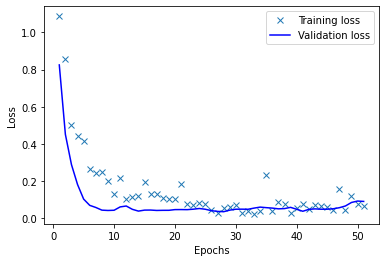

In [113]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "x", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [114]:
y_hat = dna_model.predict(X_test_pca)

6/6 [==============================] - 0s 3ms/step


In [115]:
index = np.argmax(y_hat, axis=1)
dna_pred = pd.DataFrame()
dna_pred = target_label.inverse_transform(index)

In [116]:
test_id = test['id']
submission = pd.DataFrame(test_id, columns=['id'], index=X_test.index)
submission['class'] = dna_pred
submission

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,B
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [117]:
path = '/content/drive/MyDrive/Colab Notebooks/[DACON]유전체정보_품좀_분류_AI_경진대회/submit'
os.chdir(path)
submission.to_csv("20230116_dropoutDL.csv", index = False)